# **Dataframe interchange protocol implementation for Vaex library** <br>Example Notebook

## Protocol Description
>The purpose of the **Dataframe interchange protocol (`__dataframe__`)** is to enable data interchange. I.e., a way to convert one type of dataframe into another type (for example, convert a Koalas dataframe into a Pandas dataframe, or a cuDF dataframe into a Vaex dataframe).

With the protocol implemented in dataframe libraries we will be able to write code that exepts any kind of dataframe 🎉 <br>
For more information visit the [RFC blog post](https://data-apis.org/blog/dataframe_protocol_rfc/) or the [official site](https://data-apis.org/dataframe-protocol/latest/index.html).

## Vaex description
>**Vaex library** is a high performance Python library for lazy Out-of-Core DataFrames, to visualize and explore big tabular datasets.

More about the Vaex library is available on the [official site](https://vaex.io/docs/index.html) and [blog](https://vaex.io/blog).

**The implementation for Vaex library thereby means connecting vaex dataframe class to a base class `__dataframe__` specified by the Consortium for Python Data API Standards.**

## Content

1. [dataframe attribute](#dataframe)
2. [from_dataframe method](#from_df)
3. [Plotting taxi dataset](#taxi)

<center><img src="Blog_picture_2.png" width="800"></center>

___

## `__dataframe__` attribute <a name="dataframe"></a>
The base class for the `__dataframe__` method includes three sepearate classes which are `_Buffer`, `_Column` and `_DataFrame`. Each of them has necessary and additional methods to construct and describe a dataframe. <br>Lets see some of them.

In [1]:
# First I will import Vaex protocol implementation for demo purposes
%run vaex_implementation.py

In [2]:
# Then I will construct a diverse Veax dataframe
indices = pa.array([0, 1, 2, 1, 2])
dictionary = pa.array(['foo', 'bar', 'baz'])
dict_array = pa.DictionaryArray.from_arrays(indices, dictionary)

df = vaex.from_arrays(
    numpy_int=np.array([1, 2, 3, 4, 0]), # Numpy int
    numpy_float=np.array([1.5, 2.5, 3.5, 4.5, 0]), # Numpy float
    numpy_bool=np.array([True, False, True, True, True]), # Numpy bool
    
    numpy_int_m=np.ma.array([1, 2, 3, 4, 0], mask=[0, 0, 0, 1, 1], dtype=int), # Numpy masked int
    numpy_float_m=np.ma.array([1.5, 2.5, 3.5, 4.5, 0], mask=[False, True, True, True, False], dtype=float), # Numpy masked float
    numpy_bool_m=np.ma.array([True, False, True, True, True], mask=[1, 0, 0, 1, 0], dtype=bool), # Numpy masked bool
    
    numpy_string=np.array(["a", "b", "cde", "", "f"]), # Numpy string
    numpy_string_m=np.array(["a", None, "cde", "", "f"]), # Numpy string
    
    arrow_int = pa.array([0, 1, 2, 3, 0]), # Arrow int
    arrow_float = pa.array([0.5, 1.5, 2.5, 3.5, 0.5]), # Arrow float
    arrow_bool = pa.array([True, False, True, False, True]), # Arrow bool
    
    arrow_int_m = pa.array([0, 1, 2, None, 0], mask=np.array([0, 0, 0, 1, 1], dtype=bool)), # Arrow masked int
    arrow_float_m = pa.array([0.5, 1.5, 2.5, None, 0.5], mask=np.array([0, 0, 0, 1, 0], dtype=bool)), # Arrow masked float
    arrow_bool_m = pa.array([True, False, True, None, True], mask=np.array([0, 0, 1, 1, 0], dtype=bool)), # Arrow masked bool

    arrow_string=np.array(["data", "frame", "api", "vaex", ""]), # Arrow string
    arrow_string_m=np.array(["data", "frame", None, "vaex", ""]), # Numpy string
    
    arrow_dict = pa.DictionaryArray.from_arrays(pa.array([0, 1, 2, 0, 1]), pa.array(['aap', 'noot', 'mies'])), # Arrow dictionary
    arrow_dict_m = pa.DictionaryArray.from_arrays(pa.array([0, 1, 2, 0, 1], mask=np.array([0, 1, 1, 0, 0], dtype=bool)), pa.array(['aap', 'noot', 'mies'])) # Arrow dict masked
)

# And print it out
df

#,numpy_int,numpy_float,numpy_bool,numpy_int_m,numpy_float_m,numpy_bool_m,numpy_string,numpy_string_m,arrow_int,arrow_float,arrow_bool,arrow_int_m,arrow_float_m,arrow_bool_m,arrow_string,arrow_string_m,arrow_dict,arrow_dict_m
0,1,1.5,True,1,1.5,--,a,a,0,0.5,True,0,0.5,True,data,data,aap,aap
1,2,2.5,False,2,--,False,b,--,1,1.5,False,1,1.5,False,frame,frame,noot,--
2,3,3.5,True,3,--,True,cde,cde,2,2.5,True,2,2.5,--,api,--,mies,--
3,4,4.5,True,--,--,--,,,3,3.5,False,--,--,--,vaex,vaex,aap,aap
4,0,0,True,--,0.0,True,f,f,0,0.5,True,--,0.5,True,,,noot,noot


In [3]:
# Lets first see how to call `__dataframe__` on a Vaex dataframe
df.__dataframe__()

We can see that there is a `_VaexDataFrame` class instance generated. We can now research it's attributes:

In [4]:
# Lets see the number of columns
df.__dataframe__().num_columns()

18

In [5]:
# and the number of rows
df.__dataframe__().num_rows()

5

In [6]:
# We can also get/select columns from the dataframe
# The methods that can be used are: get_column, get_column_by_name, get_columns, select_columns, select_columns_by_name
df.__dataframe__().get_column(4)

As we can see we selected the fifth column 'numpy_float_m' and got a `_VaexColumn` instance. <br>Which means we now have the fifth column of the dataframe df as a `_VaexColumn`. We can now observe some of the methods on this column also:

In [7]:
# Let's save the column and research the methods
col = df.__dataframe__().get_column(4)

# We can get the size of the column
col.size

array(5, dtype=int64)

In [8]:
# Null count
col.null_count

3

What is very useful is the null representation and the data type description of the selected column. Lets see!

In [9]:
# Null representation of the numpy int column
# 0 : non-nullable
df.__dataframe__().get_column(0).describe_null

(0, None)

In [10]:
# Null representation of the masked numpy int
# 4 : byte mask
# 1 : Value indicating a missing value
df.__dataframe__().get_column(3).describe_null

(4, 1)

In [11]:
# Null representation of the Arrow dictionary
# 3 : bit mask
# 0 : Value indicating a missing value
df.__dataframe__().get_column(17).describe_null

(3, 0)

In [12]:
# Dtype description as a tuple ``(kind, bit-width, format string, endianness)``

# Dtype description for the numpy int column
df.__dataframe__().get_column(0).dtype

(<_DtypeKind.INT: 0>, 32, '<i4', '=')

In [13]:
# Dtype description for the masked numpy float column
col.dtype

(<_DtypeKind.FLOAT: 2>, 64, '<f8', '=')

That means the fifth column of `__dataframe__` instance of dataframe df is of float type, one element of the column takes up 64 bits in computer memory. Format string will have to be mapped to Apache Arrow format string https://arrow.apache.org/docs/format/CDataInterface.html#data-type-description-format-strings. At the end of the list byteorder/endianness is also saved: https://numpy.org/doc/stable/reference/generated/numpy.dtype.byteorder.html.

In [14]:
# Dtype description for the Arrow string
df.__dataframe__().get_column(15).dtype

(21, 64, '|O', '|')

In [15]:
# Dtype description for the Arrow dictionary
df.__dataframe__().get_column(17).dtype

(<_DtypeKind.CATEGORICAL: 23>, 64, 'u', '=')

In [16]:
# We can also see description of the categorical for the Arrow dictionary
df.__dataframe__().get_column(17).describe_categorical

(False, True, {0: 'aap', 1: 'noot', 2: 'mies'})

For each column we can also get the list of the buffers. The first buffer is the data buffer, the second is the mask of the data and the third is the offest buffer. Lets see the output:

In [17]:
col.get_buffers()

{'data': (VaexBuffer({'bufsize': 40, 'ptr': 2442859086176, 'device': 'CPU'}),
  (<_DtypeKind.FLOAT: 2>, 64, '<f8', '=')),
 'validity': (VaexBuffer({'bufsize': 5, 'ptr': 2442859021152, 'device': 'CPU'}),
  (<_DtypeKind.BOOL: 20>, 8, '|b1', '|')),
 'offsets': None}

We can also see in the output that besides the `_VaexBuffer`instance we get the dtype that is needed to produce and array out from the buffer at transfer.

---

## `from_dataframe` method <a name="from_df"></a>
The general method to move between dataframes is called `from_dataframe`. It iterates through the dictionary of columns (and chunks), calls the correct methods and transfers the column to the desired type.

In this example Notebook I will show how Panas dataframe can easily be transformed to Vaex datafame.

In [18]:
# First I need to import Pandas implementation of the protocol
%run pandas_implementation.py

# And construct the example dataframe
dfp = pd.DataFrame(data=dict(a=[1, 2, 3], b=[3, 4, 5],
                             c=[1.5, 2.5, 3.5], d=["A", "B", "C"]))
dfp["b"] = dfp["b"].astype("category")
dfp.at[1, 'b'] = np.nan

# Lets first print the Pandas dataframe
dfp

,a,b,c,d
0,1,3,1.5,A
1,2,NaN,2.5,B
2,3,5,3.5,C


In [19]:
# Lets see the `__dataframe__` instance
dfp.__dataframe__()

It is in fact a Pandas dataframe and it has its `__dataframe__` base class instance. Now lets transfer it to Vaex dataframe.

In [20]:
dfp_vaex = from_dataframe_to_vaex(dfp)
dfp_vaex

#,a,b,c,d
0,1,3,1.5,A
1,2,--,2.5,B
2,3,5,3.5,C


If we check the transfered dataframe `__dataframe__` instance we see that it is now a Vaex dataframe!

In [21]:
dfp_vaex.__dataframe__()

We could now check some attributes of both classes to see if the information stayed the same.

Lets check three things:
- missing is preserved
- data type of float is preserved
- category is preserved

In [22]:
# Number of missing values in second column ('b') of the dfp
dfp.__dataframe__().get_column_by_name('b').null_count

1

In [23]:
# And the number of missing values in second column ('b') of the dfp_vaex
dfp_vaex.__dataframe__().get_column_by_name('b').null_count

1

In [24]:
# Data type of the 'c' column in dfp
dfp.__dataframe__().get_column_by_name('c').dtype

(<_DtypeKind.FLOAT: 2>, 64, '<f8', '=')

In [25]:
# Data type of the 'c' column in dfp_vaex
dfp_vaex.__dataframe__().get_column_by_name('c').dtype

(<_DtypeKind.FLOAT: 2>, 64, '<f8', '=')

In [26]:
dfp.__dataframe__().get_column_by_name('b').describe_categorical

(False, True, {0: 3, 1: 4, 2: 5})

In [27]:
dfp_vaex.__dataframe__().get_column_by_name('b').describe_categorical

(False, True, {0: 3, 1: 4, 2: 5})

**Roundtrip**<br>
We can call the `_from_dataframe_to_vaex` to see what we get with the Vaex roundtrip. We can check if the data stays the same.

In [28]:
_from_dataframe_to_vaex(df.__dataframe__())

#,numpy_int,numpy_float,numpy_bool,numpy_int_m,numpy_float_m,numpy_bool_m,numpy_string,numpy_string_m,arrow_int,arrow_float,arrow_bool,arrow_int_m,arrow_float_m,arrow_bool_m,arrow_string,arrow_string_m,arrow_dict,arrow_dict_m
0,1,1.5,True,1,1.5,--,a,a,0,0.5,True,0,0.5,True,data,data,aap,aap
1,2,2.5,False,2,--,False,b,--,1,1.5,False,1,1.5,False,frame,frame,noot,--
2,3,3.5,True,3,--,True,cde,cde,2,2.5,True,2,2.5,--,api,--,mies,--
3,4,4.5,True,--,--,--,,,3,3.5,False,--,--,--,vaex,vaex,aap,aap
4,0,0,True,--,0.0,True,f,f,0,0.5,True,--,0.5,True,,,noot,noot


In [29]:
# We can select and look at the dtype og the fifth column again
_from_dataframe_to_vaex(df.__dataframe__()).__dataframe__().get_column(4).dtype

(<_DtypeKind.FLOAT: 2>, 64, '<f8', '=')

---

## Plotting taxi dataset <a name="taxi"></a>
We can load data as Pandas dataframe and plot with Vaex function `viz.heatmap()`

In [30]:
pandas_taxi = pd.read_csv('nyc_taxi_trip_duration.csv')

In [31]:
pandas_taxi

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848
...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447


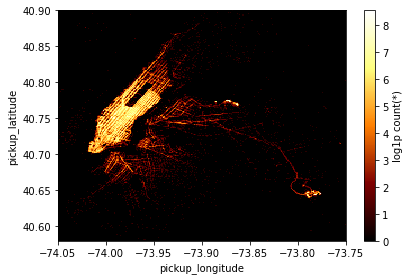

In [32]:
#creating visulization for Taxi1
vaex_taxi = from_dataframe_to_vaex(pandas_taxi)
vaex_taxi.viz.heatmap(vaex_taxi.pickup_longitude, vaex_taxi.pickup_latitude, f="log1p", limits=[[-74.05, -73.75], [40.58, 40.90]], show=True);

---

<img src="Blog_picture_5.png" width="700">

Thank you for reading through the Notebook!

If you are interested in the topic and want to see the iformation and the development of the dataframe protocol project please visit https://data-apis.org/blog/ or https://data-apis.org/dataframe-protocol/latest/index.html. 